In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

max : 3.713572
min : 0.000000
Skewness: 1.030917
Kurtosis: -0.204865

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


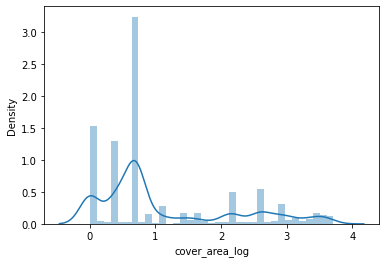

In [10]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [11]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [12]:
len(features)

3159

In [13]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]

In [14]:
len(features)

309

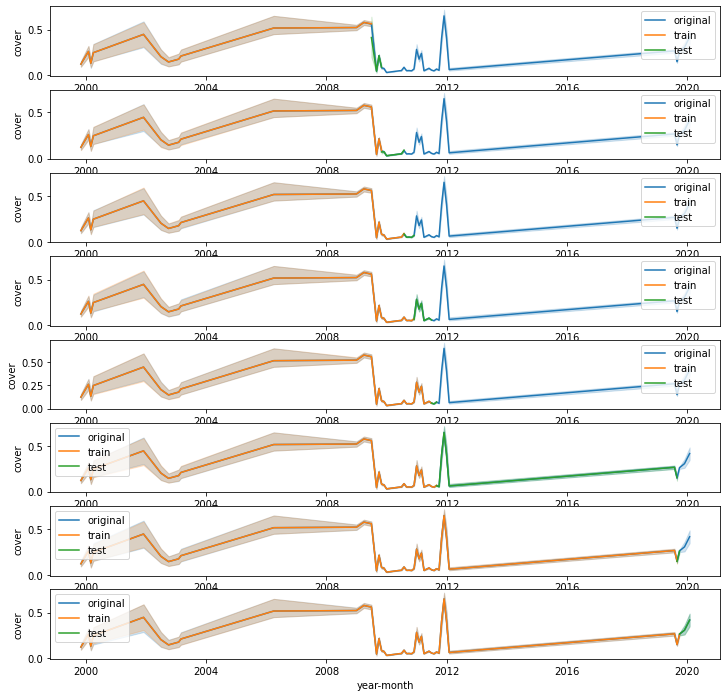

In [15]:
from sklearn.model_selection import TimeSeriesSplit

fig, axes = plt.subplots(8, 1, figsize=(12, 12))

train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
test['year-month'] = test.year.astype(int).astype(str) + '-' + test.month.astype(int).astype(str)
test['year-month'] = pd.to_datetime(test['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)

folds = TimeSeriesSplit(n_splits=8)

for i, (train_index, test_index) in enumerate(folds.split(train)):

    sns.lineplot(data=train, x='year-month', y='cover', ax=axes[i], label='original')
    # 学習用データを描く
    sns.lineplot(data=train.iloc[train_index], x='year-month', y='cover', ax=axes[i], label='train')
    # テスト用データを描く
    sns.lineplot(data=train.iloc[test_index], x='year-month', y='cover', ax=axes[i], label='test')

# グラフを表示する
plt.legend()
plt.show()

## Model

In [16]:
#!pip install iterative-stratification

In [17]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [18]:
class CFG:
  debug=False
  ver=35
  model="lightgbm"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  target_cols="cover"
  boosting_type="gbdt"  #"dart"
  fold_target="cover"

In [19]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df, fold_target):
  Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
    df.loc[train_index, f'tr_fold{n}'] = 1
    df.loc[val_index, 'va_fold'] = int(n)
    df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
    df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [20]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [21]:
#features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
#features.remove("month")
features.append("mesh20")

In [22]:
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [23]:
def get_pred(df, test, fold_target, target_cols, model, isSelect=False):

  train = get_fold(df, fold_target)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 200,
              early_stopping_rounds=50)
      
      valid_folds[f"pred"] = model.predict(valid_X)
      test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"pred"])

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"pred"])
  if isSelect:
    return oof_df, df_importance
  else:
    return oof_df,  test_preds

===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年7.0月
valid period : 2009.0年7.0月 ～ 2009.0年11.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.152347
Early stopping, best iteration is:
[156]	valid_0's rmse: 0.151768
RMSE 0.1517563616467373
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年11.0月
valid period : 2009.0年11.0月 ～ 2010.0年8.0月


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[101]	valid_0's rmse: 0.154051
RMSE 0.15405104238917364
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年12.0月


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.08442
RMSE 0.08442001306738274
===============  FOLD : 3  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年7.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[71]	valid_0's rmse: 0.137331
RMSE 0.13733095761115352
===============  FOLD : 4  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.132889
RMSE 0.13288865584603185
===============  FOLD : 5  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2019.0年9.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.226159
RMSE 0.22615894986797902
===============  FOLD : 6  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.247135
Early stopping, best iteration is:
[319]	valid_0's rmse: 0.245606


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.2456063120986486
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.199447
[400]	valid_0's rmse: 0.198182
Early stopping, best iteration is:
[386]	valid_0's rmse: 0.198102


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.19810063422818475


,feature,importance
8,lat,0.017733
281,warm_sst,0.014582
48,sst_ymd,0.012728
235,month,0.012110
87,MAX_CI,0.012079
201,lon,0.011709
102,fetch,0.011184
255,sst_diff,0.011153
15,hist_warm_sst,0.009732
226,river_dist,0.009701


RMSE 0.1736094160639047
CPU times: user 6min 15s, sys: 1.22 s, total: 6min 16s
Wall time: 54.4 s


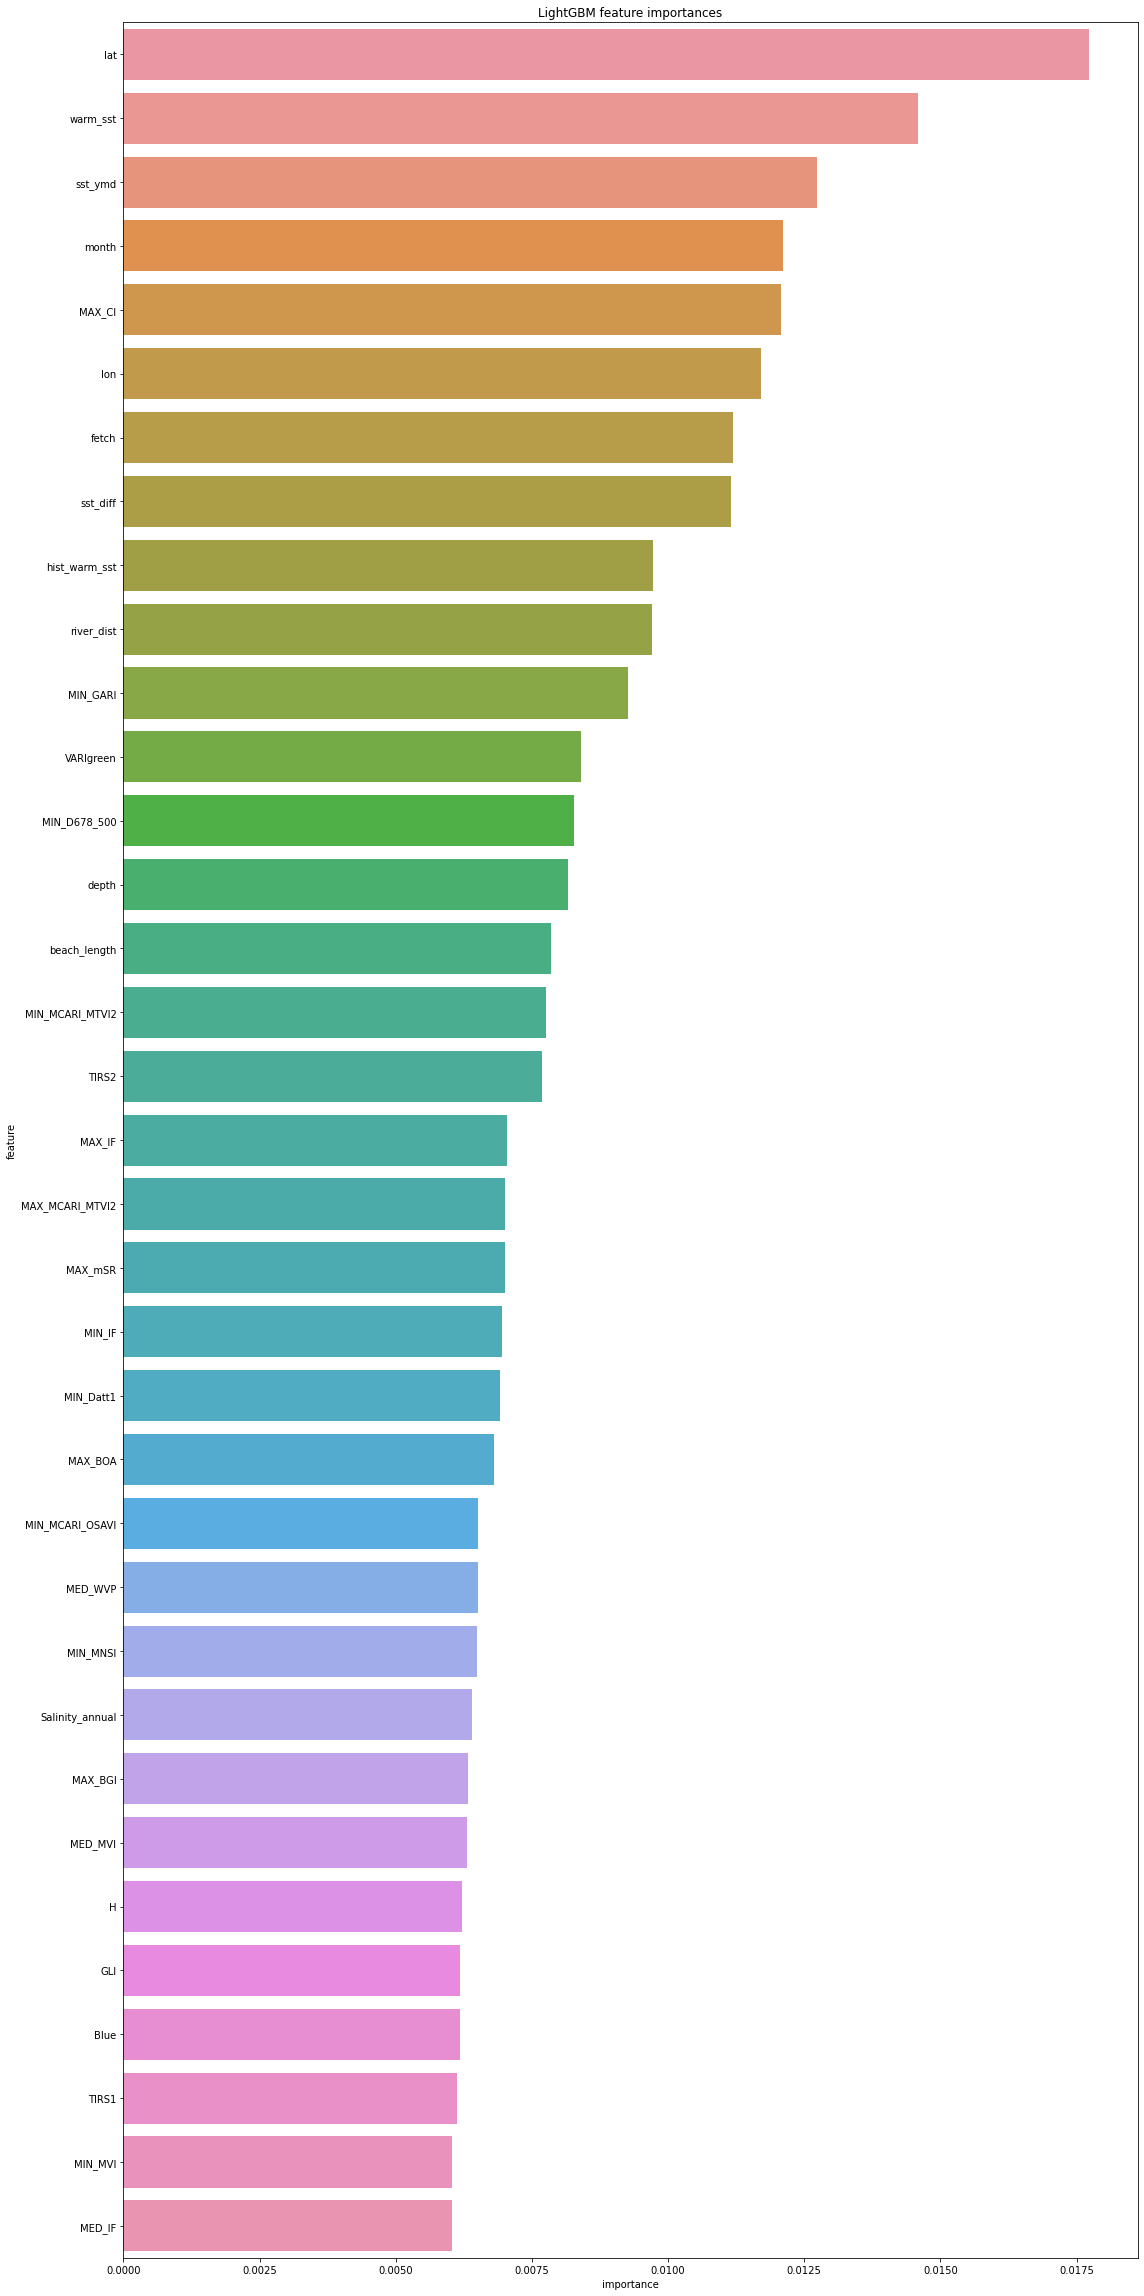

In [24]:
%%time
if CFG.debug:
  print(train.shape)
  train = train.sample(n=200, random_state=CFG.seed).reset_index(drop=True)
  train = train.sort_values("year-month").reset_index(drop=True)
  print(train.shape)

model = lgb.LGBMRegressor(**params)
select_oof, select_imp = get_pred(train, test, CFG.fold_target, CFG.target_cols, model, isSelect=True)

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

select_features = select_imp[:50].feature.tolist()

df = pd.concat([train,test]).reset_index(drop=True)
df[select_features] = IterativeImputer(RandomForestRegressor()).fit_transform(df[select_features])
train = df[~df[CFG.target_cols].isnull()]
train = train.sort_values("year-month").reset_index(drop=True)
test = df[df[CFG.target_cols].isnull()]
test = test.sort_values("id").reset_index(drop=True)

features = select_features

===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年7.0月
valid period : 2009.0年7.0月 ～ 2009.0年11.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.172506
RMSE 0.17250596348028432
===============  FOLD : 1  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年11.0月
valid period : 2009.0年11.0月 ～ 2010.0年8.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[46]	valid_0's rmse: 0.160684
RMSE 0.16068377227146857
===============  FOLD : 2  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年12.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[68]	valid_0's rmse: 0.0820699
RMSE 0.08206988578020737
===============  FOLD : 3  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年7.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.137884
RMSE 0.13788423653371648
===============  FOLD : 4  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.125219


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.12521876936811735
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2019.0年9.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.231134
Early stopping, best iteration is:
[198]	valid_0's rmse: 0.231116


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.23111624948870427
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[145]	valid_0's rmse: 0.238115
RMSE 0.23811491127187392
===============  FOLD : 7  ===============


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.144377
[400]	valid_0's rmse: 0.134477
[600]	valid_0's rmse: 0.130358
[800]	valid_0's rmse: 0.128478
[1000]	valid_0's rmse: 0.127605
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.127605


<ipython-input-23-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.1276051033767709


,feature,importance
30,GLI,0.032235
40,SWIR2,0.030323
29,H,0.027664
11,VARIgreen,0.026544
31,Blue,0.026456
12,MIN_D678_500,0.024412
6,fetch,0.023358
23,MIN_MCARI_OSAVI,0.023072
10,MIN_GARI,0.022742
1,warm_sst,0.022698


RMSE 0.1671117419029697
CPU times: user 1min 24s, sys: 1.03 s, total: 1min 25s
Wall time: 16.3 s


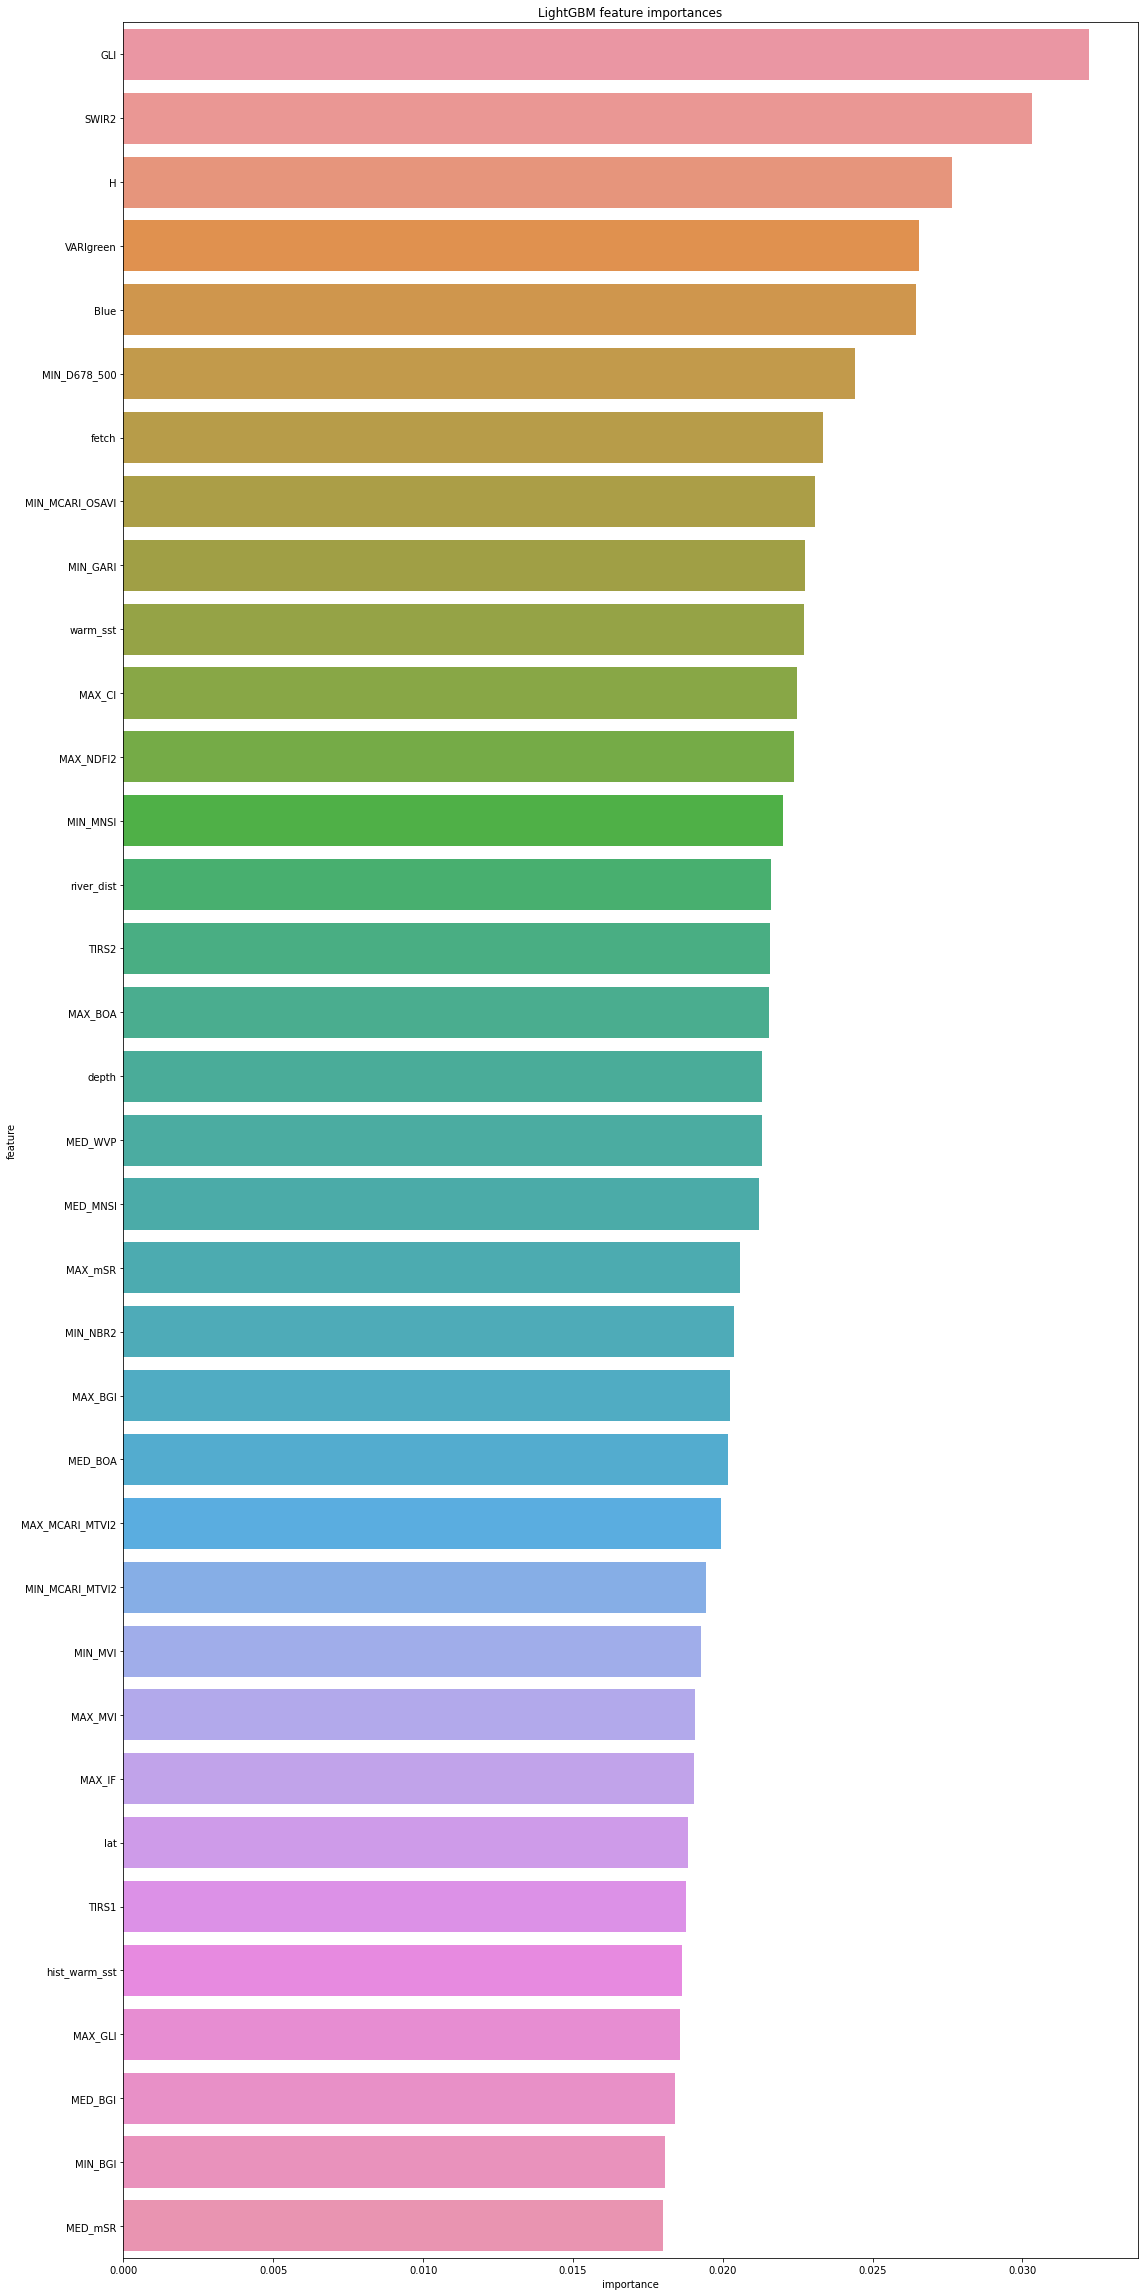

In [26]:
%%time

model = lgb.LGBMRegressor(**params)
oof_df, test_pred = get_pred(train, test, CFG.fold_target, CFG.target_cols, model)

In [27]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.16709984829735214


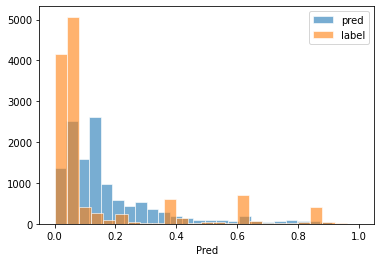

In [28]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [29]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,NaN,0.5,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043886
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113913
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,13.8,73.183418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082152
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072873
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,NaN,-0.5,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.380938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,NaN,0.4,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069400
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108290
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,0.1,76.439651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181105
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,NaN,73.660492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.167987


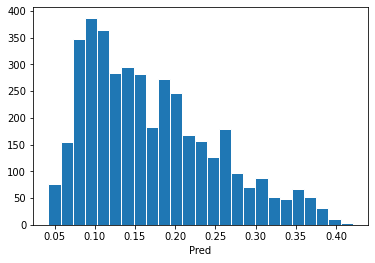

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,NaN,0.5,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043886
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113913
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,13.8,73.183418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082152
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072873
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,NaN,-0.5,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.380938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,NaN,0.4,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069400
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108290
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,0.1,76.439651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181105
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,NaN,73.660492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.167987


In [30]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [31]:
train

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,year-month,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7
0,4299,24.354412,124.202036,20.0,1999.11.8,1999.0,11.0,0.150,NaN,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
1,10451,24.351580,124.200529,20.0,1999.11.7,1999.0,11.0,0.200,NaN,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
2,13086,24.350239,124.203270,20.0,1999.11.8,1999.0,11.0,0.125,NaN,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
3,7056,24.350341,124.201675,20.0,1999.11.7,1999.0,11.0,0.030,NaN,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
4,10665,24.353195,124.202396,20.0,1999.11.8,1999.0,11.0,0.005,NaN,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,4166,24.401757,123.812260,1.5,2020.2.26,2020.0,2.0,0.650,0.40,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0
14136,8037,24.400092,123.815836,1.5,2020.2.26,2020.0,2.0,0.560,0.61,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0
14137,8637,24.400283,123.813702,1.5,2020.2.26,2020.0,2.0,0.500,0.55,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0
14138,11040,24.399529,123.815714,1.5,2020.2.26,2020.0,2.0,0.700,0.53,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0


In [33]:
OUTPUT_DF_DIR = os.path.join(OUTPUT_DIR,"DATAFRAME")

if not os.path.exists(OUTPUT_DF_DIR):
    os.makedirs(OUTPUT_DF_DIR)

train.to_csv(os.path.join(OUTPUT_DF_DIR,"exp35_train.csv"),index=False)
test.to_csv(os.path.join(OUTPUT_DF_DIR,"exp35_test.csv"),index=False)
select_imp.to_csv(os.path.join(OUTPUT_DF_DIR,"exp35_imp.csv"),index=False)